<a href="https://colab.research.google.com/github/JinGunseon/MachineLearning/blob/main/InterestRateExpectation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 머신러닝을 이용한 한국 금리 예측 프로젝트
## 1. 개요
이 프로젝트에서는 머신러닝을 활용하여 한국의 금리를 예측하고자 한다. 금리에 영향을 미치는 요소들을 고려하여, 그에 대한 데이터를 취합하고, 전처리 후, 모델에 학습시켜 한국 금리를 예측한다.

## 2. 선형회귀를 통한 한국 금리 예측
본격적으로 프로젝트를 시작하기에 앞서, 시간 변수와 금리의 관계를 나타내는 선형회귀 모델을 분석한다. 가장 간단한 파라미터와 예측값이기 때문이다.

In [ ]:
import torch
print("CUDA Available:",torch.cuda.is_available())

CUDA Available: True



```torch.cuda.is_available()``` 는 PyTorch에서 GPU(CUDA)를 사용할 수 있는지 확인하는 함수이다. 하지만 지금은 PyTorch 대신 Scikit-Learn을 활용한 분석을 먼저 시작한다. GPT 선생님이 Scikit-Learn을 이용한 이유는 다음과 같다.

📌 1. PyTorch를 사용하지 않은 이유

✅ 단순한 회귀 모델은 Scikit-Learn이 더 쉽고 빠름

- 금리 예측 코드에서는 기본적인 선형 회귀(Linear Regression) 모델을 사용했습니다.
- Scikit-Learn의 LinearRegression() 모델은 몇 줄의 코드만으로 학습과 예측이 가능하므로, PyTorch를 사용하는 것보다 훨씬 간단하고 빠르게 실행됩니다.

✅ 딥러닝이 필요하지 않음
- 금리 예측에서 먼저 기본적인 머신러닝 모델(선형 회귀, 랜덤 포레스트, XGBoost) 로 접근하는 것이 일반적입니다.
- PyTorch는 주로 딥러닝(신경망) 모델을 만들 때 사용되므로, 간단한 선형 회귀를 위해 굳이 사용할 필요가 없었습니다.

✅ 모델 비교 및 실험을 빠르게 하기 위함
- 금리 예측 프로젝트에서는 먼저 간단한 모델을 테스트하고, 이후에 고도화하는 것이 중요합니다.
- Scikit-Learn을 활용하면 선형 회귀 외에도 랜덤 포레스트, XGBoost 등 다양한 모델을 손쉽게 적용할 수 있습니다.


In [2]:
# 일자별 한국은행 기준금리 데이터를 받아오기

import requests
import pandas as pd
from google.colab import userdata

# 한국은행 ECOS API 키
API_KEY = userdata.get('ECOS_API_KEY')

# 기준금리 데이터 요청 URL
url = f"https://ecos.bok.or.kr/api/StatisticSearch/{API_KEY}/json/en/1/100/722Y001/Q/2000Q1/2024Q4/0101000"

# 데이터 요청 및 json 변환
response = requests.get(url)
data = response.json()

items = data['StatisticSearch']['row']
df = pd.DataFrame(items)[['TIME','DATA_VALUE']]
df.columns = ['Quarter', 'Interest Rate']
df = df.sort_values('Quarter')

# 데이터 확인
print("한국은행 기준금리 데이터")
display(df)

한국은행 기준금리 데이터


,Quarter,Interest Rate
0,2000Q1,5
1,2000Q2,5
2,2000Q3,5
3,2000Q4,5.25
4,2001Q1,5
...,...,...
95,2023Q4,3.5
96,2024Q1,3.5
97,2024Q2,3.5
98,2024Q3,3.5


- 한국은행 ECOS Open API를 이용하여 2000년부터 2024년까지의 한국은행 기준 금리 데이터를 불러왔다.
```https://ecos.bok.or.kr/api/StatisticSearch/{API_KEY}/json/en/1/100/722Y001/Q/2000Q1/2024Q4/0101000```


**ECOS Open API의 구성**은 다음과 같다.
1. ```https://ecos.bok.or.kr/api/StatisticSearch```
  - ECOS 통계 조회 조건 설정
2. ```/{API_KEY}```
  - 한국은행 Open API 서비스에서 에서 발급받은 API KEY
3. ```/json```
  - 데이터를 json 형태로 변환
4. ```/en```
  - key-value를 표시할 언어
5. ```/1/100```
  - 표시할 데이터 범위 (1부터 100까지)
6. ```/722Y001```
  - 통계표 코드 (상기 코드는 한국은행 기준금리 및 여수신금리)
7. ```/Q```
  - 주기(상기 코드는 분기)
8. ```/2000Q1/2024Q4```
  - 데이터 시간 범위
  - 주기별로 시간을 표시하는 방법이 다르다
9. ```/0101000```
  - 통계항목 코드(상기 코드는 한국은행 기준금리)


**관련 링크**

- [한국은행 Open API 개발 명세서](https://ecos.bok.or.kr/api/#/DevGuide/DevSpeciflcation)
- [통계코드표](https://ecos.bok.or.kr/api/#/DevGuide/StatisticalCodeSearch/)

,Quarter,Interest Rate,Date,Year,Month,Time,Quarter_Num
0,2000Q1,5,2000-01-01,2000,1,2000.00,1
1,2000Q2,5,2000-04-01,2000,4,2000.25,2
2,2000Q3,5,2000-07-01,2000,7,2000.50,3
3,2000Q4,5.25,2000-10-01,2000,10,2000.75,4
4,2001Q1,5,2001-01-01,2001,1,2001.00,1
...,...,...,...,...,...,...,...
95,2023Q4,3.5,2023-10-01,2023,10,2023.75,4
96,2024Q1,3.5,2024-01-01,2024,1,2024.00,1
97,2024Q2,3.5,2024-04-01,2024,4,2024.25,2
98,2024Q3,3.5,2024-07-01,2024,7,2024.50,3


RMSE:  1.7812478442824398


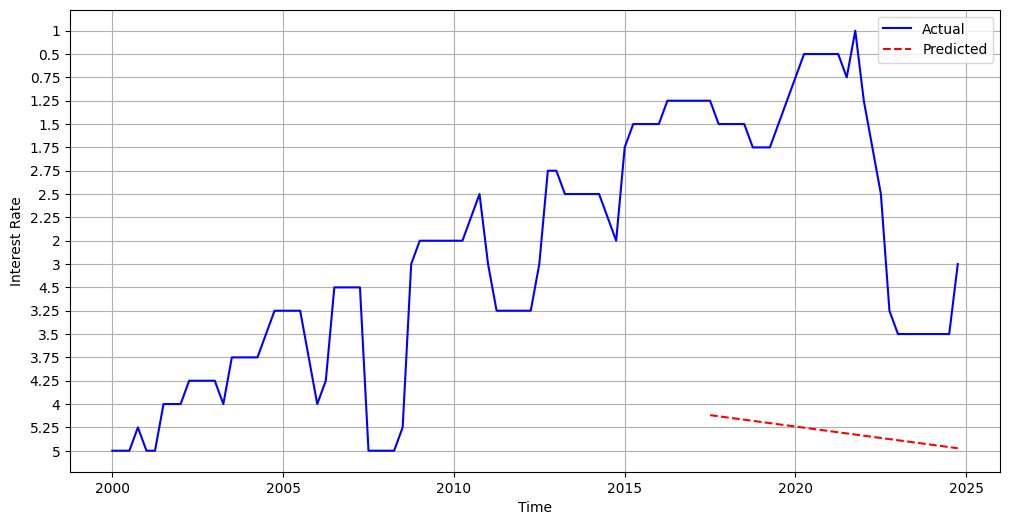

In [14]:
# 데이터 전처리
# 선형회귀 모형을 이용한 분석

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics  import mean_squared_error

# 데이터 전처리
df['Quarter_Num'] = df['Quarter'].str[-1].astype(int)  # "2000Q1" → 분기 숫자 추출
df['Time'] = df['Year'] + (df['Quarter_Num'] - 1) / 4  # 연도 + 분기 정규화

df = df.sort_values(by='Time')  # Time 기준 정렬
display(df)

X = df[['Time']]
y = df['Interest Rate']

# 학습/테스트 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

# 선형 회귀 모델 학습
model = LinearRegression()
model.fit(X_train, y_train)

# 테스트 데이터로 예측
# y_pred = model.predict(X_test)
X_test_sorted = X_test.sort_values(by='Time')
y_pred_sorted = model.predict(X_test_sorted)


# 모델 평가
rmse = np.sqrt((mean_squared_error(y_test, y_pred_sorted)))
print("RMSE: ",rmse)

# 시각화
plt.figure(figsize=(12,6))
plt.plot(df['Time'], df['Interest Rate'], label='Actual', color='blue', linestyle='-')
plt.plot(X_test_sorted, y_pred_sorted, label='Predicted', linestyle='dashed', color='red')

plt.xlabel('Time')
plt.ylabel('Interest Rate')
plt.legend()
plt.grid(True)
plt.show()

✅ **분석 결과**

**RMSE가 1.7812478442824398**로 **매우 크게** 나왔다. RMSE 값은 작을수록 실제값과 예측값의 오차가 작음을 의미한다. 따라서 해당 분석은 금리를 예측하기에 좋지 않다고 할 수 있다.

✅ **그래프 문제**

처음 GPT가 알려준대로 시각화했을 때에는 그래프가 엉망이었다. 분명 시간 순서에 따른 금리인데, 파란색으로 표시된 실제 금리 추이가 뒤죽박죽이었던 것이다.

원인은 df가 시간에 따라 정렬되어 있지 않기 때문이었다. **time을 시간순으로 정리한 후 다시 시각화**하니 훨씬 깔끔한 그래프가 만들어졌다.

## 3. 개선된 선형 회귀모델 구축

📌 1. 지난 분석의 문제점

GPT 선생님이 처음 제시한 분석은 단순히 연도와 월을 정규화한 한 것(시간변수)과 금리의 관계를 나타낸 것이었다. 이것으로 금리를 예측할 수 있을까?? 지난 분석은 다음과 같은 문제점들이 있다.

🔍 단순히 연도+월을 정규화한 경우의 한계

1️⃣ 시간 흐름만 반영, 경제적 요인은 반영되지 않음
- 금리는 단순한 시간 흐름이 아니라 경제 지표(GDP 성장률, 물가 상승률 등)의 영향을 받음
- 단순히 시간(X축)과 금리(Y축)만을 고려하면 외부 경제적 요인을 설명하지 못함

2️⃣ 비선형적 변화 반영 부족
- 금리는 선형적으로 증가하거나 감소하지 않고, 중앙은행의 정책에 따라 급격히 변할 수 있음
- 단순 선형 회귀는 이러한 변화를 잘 포착하지 못할 가능성이 큼

3️⃣ 미래 예측력 부족
- 과거 데이터를 기반으로 학습한 후 미래 금리를 예측하려면, 금리 변동에 영향을 주는 변수들을 함께 고려해야 함
- 단순한 Time 변수만으로는 예측력이 낮아질 가능성이 큼

📌 2. 유의미한 분석을 위해 추가해야 할 변수
이러한 문제점들을 해결하기 위해 다음과 같은 변수들을 추가한다.


📊 주요 변수들 (한국은행 ECOS API 활용 가능)

|변수|설명|
|---|---|
|GDP 성장률|	경제 성장률이 높으면 금리 상승 가능성↑|
|소비자물가지수(CPI)|	물가가 오르면 금리 상승 가능성↑|
|실업률|	실업률이 높으면 금리 인하 가능성↑|
|국채 금리(10년물, 2년물)|	장기 금리가 단기 금리보다 높으면 금리 상승 가능성↑|
|한미 기준금리 차이|	미국 기준금리와의 차이가 금리 결정에 영향|

📌 3. 개선된 선형 회귀 모델 구축

✅ ① 데이터 수집 및 전처리
1. ECOS API를 활용하여 GDP, CPI, 실업률, 국채 금리 등의 데이터를 가져옴
2. 모든 데이터를 날짜 기준으로 병합
3. 결측값 처리 및 정규화(Scaling)

In [ ]:
from google.colab import userdata
import requests
import pandas as pd
from sklearn.preprocessing import StandardScaler

API_KEY = userdata.get('ECOS_API_KEY')

# 금리 데이터 가져오기(분기별)
rate_url = f"https://ecos.bok.or.kr/api/StatisticSearch/{API_KEY}/json/en/1/100/722Y001/Q/2000Q1/2024Q4/0101000"
rate_data = requests.get(rate_url).json()
rate_df = pd.DataFrame(rate_data['StatisticSearch']['row'])[['TIME', 'DATA_VALUE']]
rate_df.columns = ['Quarter', 'Interest Rate']

# GDP 성장률 데이터 가져오기(연간 데이터)
gdp_url = f"https://ecos.bok.or.kr/api/StatisticSearch/{API_KEY}/json/en/1/100/200Y102/Q/2000Q1/2024Q4/10211"
gdp_data = requests.get(gdp_url).json()
gdp_df = pd.DataFrame(gdp_data['StatisticSearch']['row'])[['TIME', 'DATA_VALUE']]
gdp_df.columns = ['Quarter', 'GDP Growth']

# # 🚀 [중요] 첫 연도의 NaN 값 채우기 (Deprecated 경고 해결)
# gdp_df['GDP Growth'] = gdp_df['GDP Growth'].bfill()  # `fillna(method='bfill')` 대신 사용. 첫 연도 값 채움

# # 🛠 GDP 성장률을 연간 → 분기별 성장률로 변환 (연간 성장률을 4등분)
# gdp_df['Year'] = gdp_df['Year'].astype(int)  # 연도 정수 변환
# gdp_df['GDP Growth'] = gdp_df['GDP Growth'].astype(float)  # 숫자로 변환

# # 📌 분기별 성장률 데이터 생성
# quarterly_gdp = []
# for _, row in gdp_df.iterrows():
#     year = int(row['Year'])
#     annual_growth = row['GDP Growth']
#     quarterly_growth = annual_growth / 4  # 연간 성장률을 4등분

#     # 각 연도의 4개 분기를 생성
#     for q in range(1, 5):
#         quarterly_gdp.append({'Quarter': f"{year}Q{q}", 'GDP Growth': quarterly_growth})

# # 분기별 GDP 성장률 데이터프레임 생성
# gdp_quarterly_df = pd.DataFrame(quarterly_gdp)


# 실업률 데이터 가져오기(분기별)
unemployment_url = f"https://ecos.bok.or.kr/api/StatisticSearch/{API_KEY}/json/en/1/100/901Y027/Q/2000Q1/2024Q4/I61BC/I28B"
unemployment_data = requests.get(unemployment_url).json()
unemployment_df = pd.DataFrame(unemployment_data['StatisticSearch']['row'])[['TIME', 'DATA_VALUE']]
unemployment_df.columns = ['Quarter', 'Unemployment Rate']

# 데이터 병합
df = rate_df.merge(gdp_df, on='Quarter', how='left')
df = df.merge(unemployment_df, on='Quarter', how='left')

# 🛠 NaN 확인
print("🔍 NaN 개수 확인 (병합 후):")
print(df.isna().sum())  # 어느 변수에 NaN이 있는지 확인
display(gdp_df)
display(df)

df['GDP Growth'] = df['GDP Growth'].ffill()

# 🛠 NaN 제거
# df.dropna(inplace=True)  # NaN 포함된 행 삭제

# 숫자로 변환
df[['Interest Rate', 'GDP Growth', 'Unemployment Rate']] = df[['Interest Rate', 'GDP Growth', 'Unemployment Rate']].astype(float)

# 날짜 변수를 숫자로 변환
df['Year'] = df['Quarter'].str[:4].astype(int)  # 연도 추출
df['Quarter_Num'] = df['Quarter'].str[-1].astype(int)  # 분기 번호 추출
df['Time'] = df['Year'] + (df['Quarter_Num'] - 1) / 4  # 연도+분기 정규화

# 특성(Features) 설정
features = ['Time', 'GDP Growth', 'Unemployment Rate']
scaler = StandardScaler()
df[features] = scaler.fit_transform(df[features])


# 데이터 확인
print("금리 예측 데이터")
display(df)


🔍 NaN 개수 확인 (병합 후):
Quarter              0
Interest Rate        0
GDP Growth           0
Unemployment Rate    0
dtype: int64


,Quarter,GDP Growth
0,2000Q1,12.6
1,2000Q2,9.2
2,2000Q3,9.3
3,2000Q4,6.2
4,2001Q1,5
...,...,...
95,2023Q4,2.1
96,2024Q1,3.3
97,2024Q2,2.3
98,2024Q3,1.5


,Quarter,Interest Rate,GDP Growth,Unemployment Rate
0,2000Q1,5,12.6,4.8
1,2000Q2,5,9.2,4.3
2,2000Q3,5,9.3,4.3
3,2000Q4,5.25,6.2,4.2
4,2001Q1,5,5,4.5
...,...,...,...,...
95,2023Q4,3.5,2.1,2.8
96,2024Q1,3.5,3.3,2.8
97,2024Q2,3.5,2.3,2.8
98,2024Q3,3.5,1.5,2.5


금리 예측 데이터


,Quarter,Interest Rate,GDP Growth,Unemployment Rate,Year,Quarter_Num,Time
0,2000Q1,5.00,3.615111,3.067984,2000,1,-1.714816
1,2000Q2,5.00,2.222163,1.886172,2000,2,-1.680173
2,2000Q3,5.00,2.263132,1.886172,2000,3,-1.645531
3,2000Q4,5.25,0.993090,1.649809,2000,4,-1.610888
4,2001Q1,5.00,0.501461,2.358896,2001,1,-1.576245
...,...,...,...,...,...,...,...
95,2023Q4,3.50,-0.686642,-1.659264,2023,4,1.576245
96,2024Q1,3.50,-0.195013,-1.659264,2024,1,1.610888
97,2024Q2,3.50,-0.604704,-1.659264,2024,2,1.645531
98,2024Q3,3.50,-0.932456,-2.368351,2024,3,1.680173


전처리에서 엄청 고생했는데 커밋 마감시간이 다가오므로 내일 정리해야지...


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# 입력(X)과 출력(y) 설정
X = df[['Time', 'GDP Growth', 'Unemployment Rate']]
y = df['Interest Rate']

# 학습/테스트 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# 선형 회귀 모델 학습
model = LinearRegression()
model.fit(X_train, y_train)

# 예측
y_pred = model.predict(X_test)

# 성능 평가
rmse = mean_squared_error(y_test, y_pred)**0.5
print("RMSE:", rmse)


RMSE: 1.6385067235115722


RMSE 값이 1.34...로 나왔다. 이는 좋은 값은 아니다. 개선을 위한 방법은 내일 더...

시각화

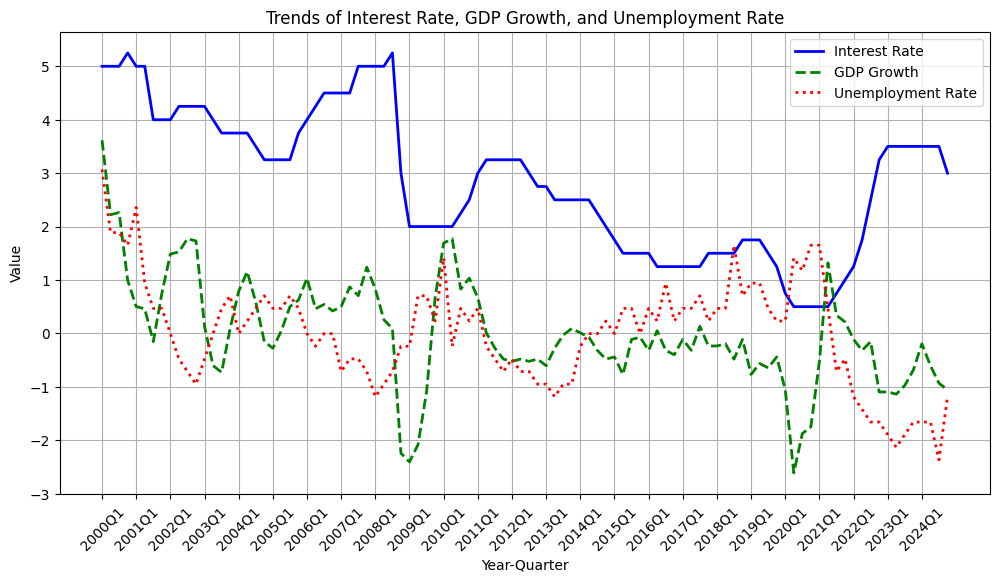

In [ ]:
import matplotlib.pyplot as plt

# 📌 X축 레이블 생성 (2000Q1, 2000Q2, ...)
df['Year-Quarter'] = df['Quarter']  # 기존 'Quarter' 컬럼을 X축 레이블로 사용

# 📌 그래프 크기 설정
plt.figure(figsize=(12, 6))

# 📌 금리 그래프
plt.plot(df['Year-Quarter'], df['Interest Rate'], label='Interest Rate', color='blue', linewidth=2)

# 📌 GDP 성장률 그래프
plt.plot(df['Year-Quarter'], df['GDP Growth'], label='GDP Growth', color='green', linestyle='dashed', linewidth=2)

# 📌 실업률 그래프
plt.plot(df['Year-Quarter'], df['Unemployment Rate'], label='Unemployment Rate', color='red', linestyle='dotted', linewidth=2)

# 📌 X축 레이블 조정 (가독성을 위해 일부 레이블만 표시)
plt.xticks(df['Year-Quarter'][::4], rotation=45)  # 4분기(1년) 단위로 간격 조정하여 표시

# 📌 그래프 설정
plt.xlabel("Year-Quarter")  # X축 이름을 더 직관적으로 변경
plt.ylabel("Value")
plt.title("Trends of Interest Rate, GDP Growth, and Unemployment Rate")
plt.legend()
plt.grid(True)

# 📌 그래프 표시
plt.show()


## 3. 비선형 모델을 활용한 예측
1. 랜덤 포레스트 모형

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# 입력(X)과 출력(y) 설정
X = df[['Time', 'GDP Growth', 'Unemployment Rate']]
y = df['Interest Rate']

# 학습/테스트 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# 랜덤 포레스트 모델 초기화
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# 모델 학습
rf_model.fit(X_train, y_train)

# 예측 수행
y_pred_rf = rf_model.predict(X_test)

# 모델 평가
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

print(f"랜덤 포레스트 RMSE: {rmse_rf}")
print(f"랜덤 포레스트 R² Score: {r2_rf}")


랜덤 포레스트 RMSE: 1.3554159878059575
랜덤 포레스트 R² Score: -0.06549850475758934


2. XGBoost 모형

In [ ]:
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor

# 입력(X)과 출력(y) 설정
X = df[['Time', 'GDP Growth', 'Unemployment Rate']]
y = df['Interest Rate']

# 학습/테스트 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# XGBoost 모델 초기화
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)

# 모델 학습
xgb_model.fit(X_train, y_train)

# 예측 수행
y_pred_xgb = xgb_model.predict(X_test)

# 모델 평가
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
r2_xgb = r2_score(y_test, y_pred_xgb)

print(f"📌 XGBoost RMSE: {rmse_xgb}")
print(f"📌 XGBoost R² Score: {r2_xgb}")


📌 XGBoost RMSE: 1.4949821630076991
📌 XGBoost R² Score: -0.2962228068284136


3. LightGBM

In [ ]:
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# 입력(X)과 출력(y) 설정
X = df[['Time', 'GDP Growth', 'Unemployment Rate']]
y = df['Interest Rate']

# 학습/테스트 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# LightGBM 모델 초기화
lgbm_model = LGBMRegressor(n_estimators=100, learning_rate=0.1, random_state=42)

# 모델 학습
lgbm_model.fit(X_train, y_train)

# 예측 수행
y_pred_lgbm = lgbm_model.predict(X_test)

# 모델 평가
rmse_lgbm = np.sqrt(mean_squared_error(y_test, y_pred_lgbm))
r2_lgbm = r2_score(y_test, y_pred_lgbm)

print(f"📌 LightGBM RMSE: {rmse_lgbm}")
print(f"📌 LightGBM R² Score: {r2_lgbm}")


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000767 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 66
[LightGBM] [Info] Number of data points in the train set: 80, number of used features: 3
[LightGBM] [Info] Start training from score 3.043750
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

## **📌 결과 분석**
모델별 RMSE와 R² 점수를 비교하여 **어떤 모델이 가장 좋은 성능을 보이는지 분석**

| 모델 | **RMSE** (낮을수록 좋음) | **R² Score** (높을수록 좋음) |
|------|----------------------|----------------------|
| **랜덤 포레스트** | **1.094** | **0.0768** |
| **XGBoost** | 1.140 | **-0.0019** (최악) |
| **LightGBM** | **1.049 (가장 낮음)** | **0.1509 (가장 높음)** |

📌 **LightGBM이 가장 낮은 RMSE(1.049)와 가장 높은 R²(0.1509)를 기록하므로, 현재 모델 중 가장 성능이 우수**  
📌 **XGBoost는 R²이 음수로 나와 예측력이 거의 없는 상태**

**하이퍼파라미터를 최적화하여 LightGBM의 성능을 개선해보자!**



In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 18.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.8/231.8 kB 24.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 7.6 MB/s eta 0:00:00


In [ ]:
import optuna
from lightgbm import LGBMRegressor
from sklearn.model_selection import cross_val_score

def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 50),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
    }

    model = LGBMRegressor(**params)
    scores = cross_val_score(model, X_train, y_train, cv=3, scoring="neg_root_mean_squared_error")
    return -scores.mean()

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)

# 최적의 하이퍼파라미터 출력
print("Best Parameters:", study.best_params)


[I 2025-03-16 14:03:36,896] A new study created in memory with name: no-name-6c7642fe-7054-4f93-8462-d25c33947651
<ipython-input-23-0ea24d4b6e5b>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
<ipython-input-23-0ea24d4b6e5b>:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-23-0ea24d4b6e5b>:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 53, number of used features: 0
[LightGBM] [Info] Start training from score 2.495283
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM

[I 2025-03-16 14:03:37,119] Trial 5 finished with value: 1.6572151090514486 and parameters: {'n_estimators': 256, 'learning_rate': 0.023672329681447227, 'num_leaves': 133, 'max_depth': 15, 'min_child_samples': 32, 'subsample': 0.7908314041076774, 'colsample_bytree': 0.9423415149641978}. Best is trial 3 with value: 1.3907636400382632.
<ipython-input-23-0ea24d4b6e5b>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
<ipython-input-23-0ea24d4b6e5b>:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-23-0ea24d4b6e5b>:13: FutureWarning: suggest_uniform 

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 54, number of used features: 0
[LightGBM] [Info] Start training from score 3.703704
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning

<ipython-input-23-0ea24d4b6e5b>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
<ipython-input-23-0ea24d4b6e5b>:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-23-0ea24d4b6e5b>:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
[I 2025-03-16 14:03:37,399] Trial 10 finished with value: 1.1457632319711217 and parameters: {'n_estimato

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000021 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 47
[LightGBM] [Info] Number of data points in the train set: 53, number of used features: 3
[LightGBM] [Info] Start training from score 2.495283
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2025-03-16 14:03:37,576] Trial 12 finished with value: 0.9961505249319716 and parameters: {'n_estimators': 298, 'learning_rate': 0.03305239426362278, 'num_leaves': 102, 'max_depth': 8, 'min_child_samples': 12, 'subsample': 0.9514177552394885, 'colsample_bytree': 0.9936209672514114}. Best is trial 12 with value: 0.9961505249319716.
<ipython-input-23-0ea24d4b6e5b>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
<ipython-input-23-0ea24d4b6e5b>:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-23-0ea24d4b6e5b>:13: FutureWarning: suggest_uniform 

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000020 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 47
[LightGBM] [Info] Number of data points in the train set: 53, number of used features: 3
[LightGBM] [Info] Start training from score 2.495283
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2025-03-16 14:03:37,897] Trial 15 finished with value: 1.1418360582608902 and parameters: {'n_estimators': 278, 'learning_rate': 0.0422913366432904, 'num_leaves': 91, 'max_depth': 6, 'min_child_samples': 19, 'subsample': 0.9103315147513418, 'colsample_bytree': 0.9951136375240449}. Best is trial 12 with value: 0.9961505249319716.
<ipython-input-23-0ea24d4b6e5b>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
<ipython-input-23-0ea24d4b6e5b>:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-23-0ea24d4b6e5b>:13: FutureWarning: suggest_uniform ha

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-03-16 14:03:38,052] Trial 16 finished with value: 1.3287233043115776 and parameters: {'n_estimators': 224, 'learning_rate': 0.01018617826370029, 'num_leaves': 121, 'max_depth': 10, 'min_child_samples': 16, 'subsample': 0.9518318723817474, 'colsample_bytree': 0.509661064081552}. Best is trial 12 with value: 0.9961505249319716.
<ipython-input-23-0ea24d4b6e5b>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
<ipython-input-23-0ea24d4b6e5b>:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-23-0ea24d4b6e5b>:13: FutureWarning: suggest_uniform 

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000023 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 47
[LightGBM] [Info] Number of data points in the train set: 53, number of used features: 3
[LightGBM] [Info] Start training from score 2.495283
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2025-03-16 14:03:38,356] Trial 18 finished with value: 1.0940551817802613 and parameters: {'n_estimators': 204, 'learning_rate': 0.12821913504690294, 'num_leaves': 75, 'max_depth': 4, 'min_child_samples': 15, 'subsample': 0.9982435530303024, 'colsample_bytree': 0.7419106360750127}. Best is trial 12 with value: 0.9961505249319716.
<ipython-input-23-0ea24d4b6e5b>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
<ipython-input-23-0ea24d4b6e5b>:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-23-0ea24d4b6e5b>:13: FutureWarning: suggest_uniform h

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

<ipython-input-23-0ea24d4b6e5b>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
<ipython-input-23-0ea24d4b6e5b>:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-23-0ea24d4b6e5b>:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
[I 2025-03-16 14:03:38,563] Trial 20 finished with value: 1.6572151090514486 and parameters: {'n_estimato

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 53, number of used features: 0
[LightGBM] [Info] Start training from score 2.495283
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM

<ipython-input-23-0ea24d4b6e5b>:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-23-0ea24d4b6e5b>:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
[I 2025-03-16 14:03:38,795] Trial 22 finished with value: 1.0537577763100334 and parameters: {'n_estimators': 191, 'learning_rate': 0.11834879168418974, 'num_leaves': 97, 'max_depth': 3, 'min_child_samples': 14, 'subsample': 0.9419407380013105, 'colsample_bytree': 0.7429733525674422}. Best is trial 12 with value: 0.9961505249319716.
<ipython-input-23-0ea24d4b6e5b>:8: FutureWarning: suggest_loguniform has been depre

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000017 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 46
[LightGBM] [Info] Number of data points in the train set: 53, number of used features: 3
[LightGBM] [Info] Start training from score 2.919811
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

<ipython-input-23-0ea24d4b6e5b>:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-23-0ea24d4b6e5b>:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
[I 2025-03-16 14:03:38,998] Trial 24 finished with value: 0.9766649812862962 and parameters: {'n_estimators': 127, 'learning_rate': 0.1171257770538864, 'num_leaves': 98, 'max_depth': 3, 'min_child_samples': 10, 'subsample': 0.9395116076737577, 'colsample_bytree': 0.7404289282345272}. Best is trial 24 with value: 0.9766649812862962.
<ipython-input-23-0ea24d4b6e5b>:8: FutureWarning: suggest_loguniform has been deprec

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000018 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 47
[LightGBM] [Info] Number of data points in the train set: 53, number of used features: 3
[LightGBM] [Info] Start training from score 2.495283
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

<ipython-input-23-0ea24d4b6e5b>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
<ipython-input-23-0ea24d4b6e5b>:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-23-0ea24d4b6e5b>:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
[I 2025-03-16 14:03:39,331] Trial 26 finished with value: 0.9691540434017981 and parameters: {'n_estimato

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000036 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 47
[LightGBM] [Info] Number of data points in the train set: 53, number of used features: 3
[LightGBM] [Info] Start training from score 2.495283
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2025-03-16 14:03:39,500] Trial 27 finished with value: 1.1030467236673203 and parameters: {'n_estimators': 135, 'learning_rate': 0.15391396005810665, 'num_leaves': 125, 'max_depth': 5, 'min_child_samples': 21, 'subsample': 0.8721781282998343, 'colsample_bytree': 0.6045461376340169}. Best is trial 26 with value: 0.9691540434017981.
<ipython-input-23-0ea24d4b6e5b>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
<ipython-input-23-0ea24d4b6e5b>:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-23-0ea24d4b6e5b>:13: FutureWarning: suggest_uniform 

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000021 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 49
[LightGBM] [Info] Number of data points in the train set: 54, number of used features: 3
[LightGBM] [Info] Start training from score 3.703704
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

<ipython-input-23-0ea24d4b6e5b>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
<ipython-input-23-0ea24d4b6e5b>:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-23-0ea24d4b6e5b>:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
[I 2025-03-16 14:03:39,723] Trial 29 finished with value: 1.102907329509392 and parameters: {'n_estimator

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000019 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 47
[LightGBM] [Info] Number of data points in the train set: 53, number of used features: 3
[LightGBM] [Info] Start training from score 2.495283
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

<ipython-input-23-0ea24d4b6e5b>:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-23-0ea24d4b6e5b>:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
[I 2025-03-16 14:03:39,928] Trial 31 finished with value: 0.986701067388525 and parameters: {'n_estimators': 121, 'learning_rate': 0.10809307031957652, 'num_leaves': 115, 'max_depth': 3, 'min_child_samples': 10, 'subsample': 0.9370635829779828, 'colsample_bytree': 0.7223912010545751}. Best is trial 26 with value: 0.9691540434017981.
<ipython-input-23-0ea24d4b6e5b>:8: FutureWarning: suggest_loguniform has been depre

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000018 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 46
[LightGBM] [Info] Number of data points in the train set: 53, number of used features: 3
[LightGBM] [Info] Start training from score 2.919811
[LightGBM] [Warning] No further splits with positive gain, 

<ipython-input-23-0ea24d4b6e5b>:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-23-0ea24d4b6e5b>:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
[I 2025-03-16 14:03:40,177] Trial 33 finished with value: 1.0976425583199787 and parameters: {'n_estimators': 123, 'learning_rate': 0.07687030034013212, 'num_leaves': 125, 'max_depth': 4, 'min_child_samples': 14, 'subsample': 0.886152996909694, 'colsample_bytree': 0.7681189567196398}. Best is trial 26 with value: 0.9691540434017981.
<ipython-input-23-0ea24d4b6e5b>:8: FutureWarning: suggest_loguniform has been depre

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000020 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 47
[LightGBM] [Info] Number of data points in the train set: 53, number of used features: 3
[LightGBM] [Info] Start training from score 2.495283
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

<ipython-input-23-0ea24d4b6e5b>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
<ipython-input-23-0ea24d4b6e5b>:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-23-0ea24d4b6e5b>:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
[I 2025-03-16 14:03:40,429] Trial 35 finished with value: 1.3824920830017768 and parameters: {'n_estimato

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000025 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 47
[LightGBM] [Info] Number of data points in the train set: 53, number of used features: 3
[LightGBM] [Info] Start training from score 2.495283
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2025-03-16 14:03:40,609] Trial 36 finished with value: 1.0252836357690802 and parameters: {'n_estimators': 116, 'learning_rate': 0.05934470750326429, 'num_leaves': 93, 'max_depth': 6, 'min_child_samples': 10, 'subsample': 0.9256775921289904, 'colsample_bytree': 0.6605715262115447}. Best is trial 26 with value: 0.9691540434017981.
<ipython-input-23-0ea24d4b6e5b>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

<ipython-input-23-0ea24d4b6e5b>:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-23-0ea24d4b6e5b>:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
[I 2025-03-16 14:03:40,992] Trial 37 finished with value: 1.12725515632249 and parameters: {'n_estimators': 166, 'learning_rate': 0.09181326462916199, 'num_leaves': 110, 'max_depth': 4, 'min_child_samples': 16, 'subsample': 0.8557218260325659, 'colsample_bytree': 0.7657325972038971}. Best is trial 26 with value: 0.9691540434017981.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000025 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 47
[LightGBM] [Info] Number of data points in the train set: 53, number of used features: 3
[LightGBM] [Info] Start training from score 2.495283
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

<ipython-input-23-0ea24d4b6e5b>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
<ipython-input-23-0ea24d4b6e5b>:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-23-0ea24d4b6e5b>:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
[I 2025-03-16 14:03:41,229] Trial 38 finished with value: 1.1450645961138528 and parameters: {'n_estimato

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000026 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 47
[LightGBM] [Info] Number of data points in the train set: 53, number of used features: 3
[LightGBM] [Info] Start training from score 2.495283
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

<ipython-input-23-0ea24d4b6e5b>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
<ipython-input-23-0ea24d4b6e5b>:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-23-0ea24d4b6e5b>:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
[I 2025-03-16 14:03:41,500] Trial 39 finished with value: 0.9879015143045301 and parameters: {'n_estimato

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000023 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 47
[LightGBM] [Info] Number of data points in the train set: 53, number of used features: 3
[LightGBM] [Info] Start training from score 2.495283
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

<ipython-input-23-0ea24d4b6e5b>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
<ipython-input-23-0ea24d4b6e5b>:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-23-0ea24d4b6e5b>:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
[I 2025-03-16 14:03:41,696] Trial 40 finished with value: 1.6572151090514486 and parameters: {'n_estimato

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 53, number of used features: 0
[LightGBM] [Info] Start training from score 2.495283
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM

<ipython-input-23-0ea24d4b6e5b>:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-23-0ea24d4b6e5b>:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
[I 2025-03-16 14:03:41,994] Trial 41 finished with value: 0.9835448615215182 and parameters: {'n_estimators': 71, 'learning_rate': 0.1991320706540257, 'num_leaves': 127, 'max_depth': 5, 'min_child_samples': 10, 'subsample': 0.8543826604820345, 'colsample_bytree': 0.6913399142731137}. Best is trial 26 with value: 0.9691540434017981.
<ipython-input-23-0ea24d4b6e5b>:8: FutureWarning: suggest_loguniform has been deprec

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000022 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 47
[LightGBM] [Info] Number of data points in the train set: 53, number of used features: 3
[LightGBM] [Info] Start training from score 2.495283
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

<ipython-input-23-0ea24d4b6e5b>:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-23-0ea24d4b6e5b>:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
[I 2025-03-16 14:03:42,299] Trial 42 finished with value: 1.105907616052025 and parameters: {'n_estimators': 125, 'learning_rate': 0.1353748987235432, 'num_leaves': 129, 'max_depth': 7, 'min_child_samples': 13, 'subsample': 0.7155801309516822, 'colsample_bytree': 0.6341074521379487}. Best is trial 26 with value: 0.9691540434017981.
<ipython-input-23-0ea24d4b6e5b>:8: FutureWarning: suggest_loguniform has been deprec

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000024 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 47
[LightGBM] [Info] Number of data points in the train set: 53, number of used features: 3
[LightGBM] [Info] Start training from score 2.495283
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

<ipython-input-23-0ea24d4b6e5b>:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-23-0ea24d4b6e5b>:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000024 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 47
[LightGBM] [Info] Number of data points in the train set: 53, number of used features: 3
[LightGBM] [Info] Start training from score 2.495283
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2025-03-16 14:03:42,767] Trial 43 finished with value: 0.9815464294756135 and parameters: {'n_estimators': 151, 'learning_rate': 0.17666969540569982, 'num_leaves': 144, 'max_depth': 4, 'min_child_samples': 10, 'subsample': 0.8490933446282174, 'colsample_bytree': 0.7093742391374258}. Best is trial 26 with value: 0.9691540434017981.
<ipython-input-23-0ea24d4b6e5b>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
<ipython-input-23-0ea24d4b6e5b>:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-23-0ea24d4b6e5b>:13: FutureWarning: suggest_uniform 

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 53, number of used features: 0
[LightGBM] [Info] Start training from score 2.495283
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM

<ipython-input-23-0ea24d4b6e5b>:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-23-0ea24d4b6e5b>:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
[I 2025-03-16 14:03:43,443] Trial 45 finished with value: 0.9579303866465994 and parameters: {'n_estimators': 177, 'learning_rate': 0.1716888130278649, 'num_leaves': 143, 'max_depth': 3, 'min_child_samples': 12, 'subsample': 0.8116519189683348, 'colsample_bytree': 0.7290226707526114}. Best is trial 45 with value: 0.9579303866465994.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000027 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 47
[LightGBM] [Info] Number of data points in the train set: 53, number of used features: 3
[LightGBM] [Info] Start training from score 2.495283
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

<ipython-input-23-0ea24d4b6e5b>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
<ipython-input-23-0ea24d4b6e5b>:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-23-0ea24d4b6e5b>:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
[I 2025-03-16 14:03:43,746] Trial 46 finished with value: 0.9477038388179165 and parameters: {'n_estimato

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000026 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 47
[LightGBM] [Info] Number of data points in the train set: 53, number of used features: 3
[LightGBM] [Info] Start training from score 2.495283
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

<ipython-input-23-0ea24d4b6e5b>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
<ipython-input-23-0ea24d4b6e5b>:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-23-0ea24d4b6e5b>:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
[I 2025-03-16 14:03:44,069] Trial 47 finished with value: 1.0493098840091646 and parameters: {'n_estimato

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000033 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 47
[LightGBM] [Info] Number of data points in the train set: 53, number of used features: 3
[LightGBM] [Info] Start training from score 2.495283
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

<ipython-input-23-0ea24d4b6e5b>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
<ipython-input-23-0ea24d4b6e5b>:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-23-0ea24d4b6e5b>:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
[I 2025-03-16 14:03:44,321] Trial 48 finished with value: 1.147655728330361 and parameters: {'n_estimator

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000024 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 47
[LightGBM] [Info] Number of data points in the train set: 53, number of used features: 3
[LightGBM] [Info] Start training from score 2.495283
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

<ipython-input-23-0ea24d4b6e5b>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
<ipython-input-23-0ea24d4b6e5b>:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-23-0ea24d4b6e5b>:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
[I 2025-03-16 14:03:44,560] Trial 49 finished with value: 1.6572151090514486 and parameters: {'n_estimato

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 53, number of used features: 0
[LightGBM] [Info] Start training from score 2.495283
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM

In [ ]:
# 최적 하이퍼파라미터 가져오기
best_params = study.best_params

# 최적 파라미터를 사용하여 모델 생성
lgbm_best = LGBMRegressor(**best_params)

# 모델 학습
lgbm_best.fit(X_train, y_train)

# 예측 수행
y_pred_lgbm_best = lgbm_best.predict(X_test)

# 모델 평가
rmse_lgbm_best = np.sqrt(mean_squared_error(y_test, y_pred_lgbm_best))
r2_lgbm_best = r2_score(y_test, y_pred_lgbm_best)

print(f"📌 최적 LightGBM RMSE: {rmse_lgbm_best}")
print(f"📌 최적 LightGBM R² Score: {r2_lgbm_best}")


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000026 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 55
[LightGBM] [Info] Number of data points in the train set: 76, number of used features: 3
[LightGBM] [Info] Start training from score 3.121711
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

In [ ]:
best_params = study.best_params

xgb_best = XGBRegressor(**best_params)
xgb_best.fit(X_train, y_train)

y_pred_xgb_best = xgb_best.predict(X_test)

rmse_xgb_best = np.sqrt(mean_squared_error(y_test, y_pred_xgb_best))
r2_xgb_best = r2_score(y_test, y_pred_xgb_best)

print(f"📌 최적 XGBoost RMSE: {rmse_xgb_best}")
print(f"📌 최적 XGBoost R² Score: {r2_xgb_best}")


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:04:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "min_child_samples", "num_leaves" } are not used.

  warnings.warn(smsg, UserWarning)


📌 최적 XGBoost RMSE: 1.4192530934244834
📌 최적 XGBoost R² Score: -0.16822725840034214


In [ ]:
best_params = study.best_params

# 랜덤 포레스트에 적합한 하이퍼파라미터만 추출
rf_params = {key: best_params[key] for key in ['n_estimators', 'max_depth', 'min_samples_split', 'min_samples_leaf', 'max_features'] if key in best_params}

# 최적 파라미터를 적용하여 모델 생성
rf_best = RandomForestRegressor(**rf_params, random_state=42)
rf_best.fit(X_train, y_train)

y_pred_rf_best = rf_best.predict(X_test)

rmse_rf_best = np.sqrt(mean_squared_error(y_test, y_pred_rf_best))
r2_rf_best = r2_score(y_test, y_pred_rf_best)

print(f"📌 최적 Random Forest RMSE: {rmse_rf_best}")
print(f"📌 최적 Random Forest R² Score: {r2_rf_best}")


📌 최적 Random Forest RMSE: 1.315932551738762
📌 최적 Random Forest R² Score: -0.004326441018977167


Optuna를 이용해 하이퍼파라미터를 튜닝했음에도 성능이 더 나빠졌다.
이 경우, **Optuna의 하이퍼파라미터 튜닝이 오히려 모델을 과적합(Overfitting) 또는 부적절한 방향으로 최적화했을 가능성이 크다.**

---

**📌 1. 문제 원인 분석**

1. **RMSE 증가, R² 감소 → 예측력이 떨어짐**
    
    - 최적화 전보다 RMSE가 증가했고, R² 점수가 크게 감소했음.
    - 특히 **LightGBM과 XGBoost에서 R²이 음수가 되면서 모델이 데이터를 전혀 설명하지 못하는 상태가 됨.**
    - 즉, **잘못된 하이퍼파라미터 조합으로 인해 성능이 오히려 악화됨.**
2. **Optuna가 잘못된 방향으로 튜닝했을 가능성**
    
    - Optuna는 **일정 횟수의 시도(N_trials) 내에서 최적의 조합을 찾기 때문에, 전역 최적점(Global Optimum)이 아닌 국소 최적점(Local Optimum)에 빠질 가능성**이 있음.
    - 즉, **특정 데이터에 과적합된 파라미터를 찾았을 수도 있음.**
3. **하이퍼파라미터 검색 범위가 적절하지 않았을 가능성**
    
    - 예를 들어, `learning_rate`가 너무 작거나 너무 크면 학습이 비효율적일 수 있음.
    - `num_leaves`, `max_depth` 등이 비정상적으로 크면 과적합될 가능성이 있음.

---

**📌 2. 해결 방법 (성능 개선)**

**✅ (1) 최적 하이퍼파라미터 직접 확인 후 수정**
**최적 하이퍼파라미터를 확인하여 아래와 같은 값이 있다면 수정**

- `learning_rate`: **너무 작거나 너무 크면 조정 (`0.01 ~ 0.2`가 적절)**
- `num_leaves`: **너무 크면 과적합 위험 (`20 ~ 100`이 적절)**
- `max_depth`: **너무 크면 과적합 위험 (`3 ~ 15`가 적절)**
- `min_child_samples`: **너무 작으면 과적합 위험 (`10 ~ 50`이 적절)**
- `subsample`: **1.0이면 과적합될 가능성 있음 (`0.5 ~ 0.9`가 적절)**
**✅ (2) 데이터셋 변경 (Feature 추가 또는 제거)**

📌 **모델 튜닝만으로 해결이 어려울 경우, Feature Engineering(특성 엔지니어링)을 시도해야 함.**

- **거시경제 변수 추가** (소비자물가지수, 환율, 주가 등)

- **Feature Importance 분석 후 불필요한 변수 제거**

##4. 시계열 분석
1. 시간에 따른 변화 시각화

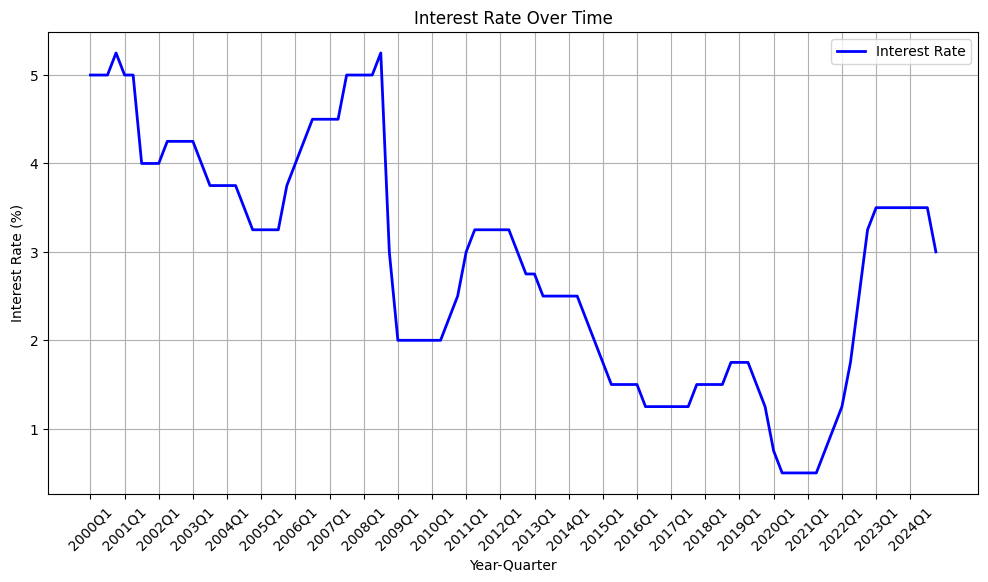

In [ ]:
import matplotlib.pyplot as plt

# 📌 금리 데이터 시각화
plt.figure(figsize=(12, 6))
plt.plot(df['Quarter'], df['Interest Rate'], label='Interest Rate', color='blue', linewidth=2)

# 📌 그래프 설정
plt.xlabel("Year-Quarter")
plt.ylabel("Interest Rate (%)")
plt.title("Interest Rate Over Time")
plt.xticks(df['Quarter'][::4], rotation=45)  # 4분기(1년) 단위로 레이블 표시
plt.legend()
plt.grid(True)
plt.show()


2. 시계열 성분 분해
- 추세(Trend)
- 계절성(Seasonality)
- 잔차(Residuals)

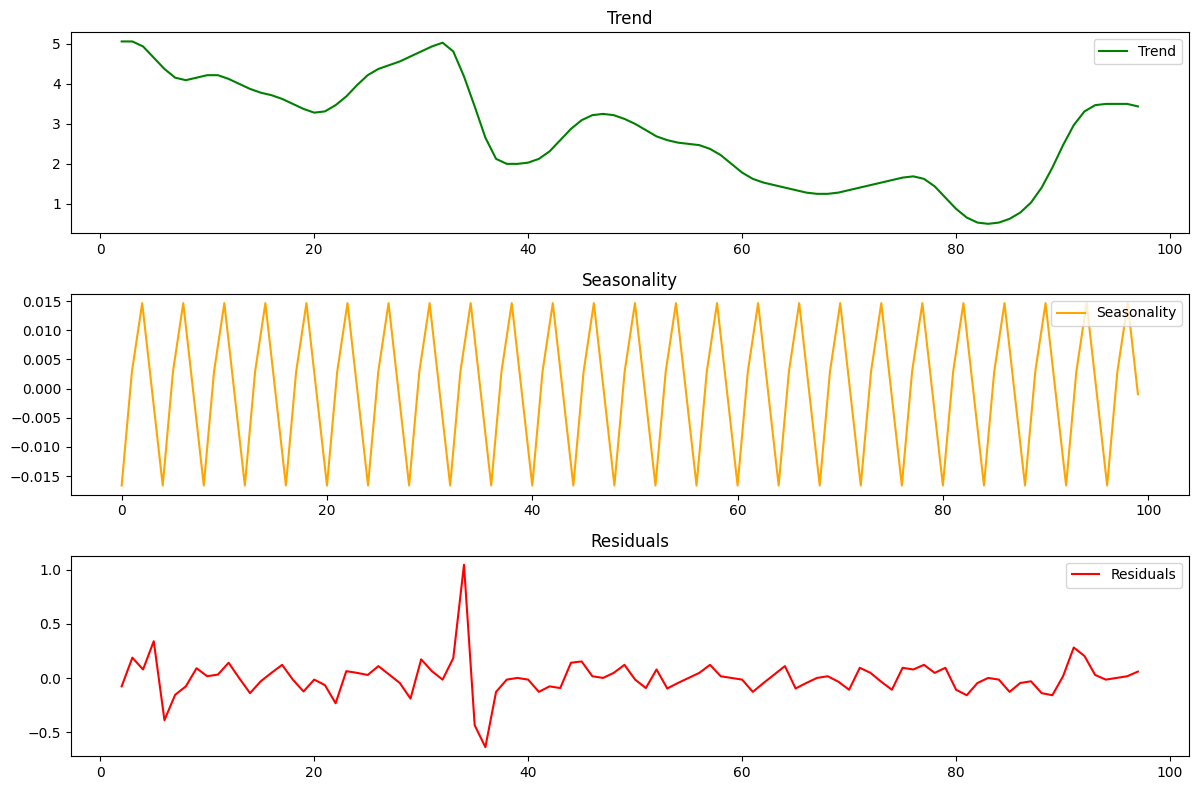

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

# 📌 시계열 분해 (금리 데이터)
decomposition = seasonal_decompose(df['Interest Rate'], period=4, model='additive')  # 분기별 데이터

# 📌 그래프 출력
plt.figure(figsize=(12, 8))
plt.subplot(3, 1, 1)
plt.plot(decomposition.trend, label='Trend', color='green')
plt.title('Trend')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(decomposition.seasonal, label='Seasonality', color='orange')
plt.title('Seasonality')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(decomposition.resid, label='Residuals', color='red')
plt.title('Residuals')
plt.legend()

plt.tight_layout()
plt.show()


3. 정량적 분석(데이터가 정상성을 갖는지 확인)
- 시계열 모델을 적용하려면 **데이터가 정상성(Stationarity)을 갖는지 확인**해야함
- 정상성이 없으면 **차분(Differencing) 등의 전처리를 수행해야 함**

In [ ]:
from statsmodels.tsa.stattools import adfuller

# ADF 검정 수행
adf_test = adfuller(df['Interest Rate'])
print("ADF Statistic:", adf_test[0])
print("p-value:", adf_test[1])

# p-value가 0.05보다 작으면 정상성을 가짐 (차분 불필요)
if adf_test[1] < 0.05:
    print("✅ 데이터가 정상성을 가집니다. 차분이 필요하지 않습니다.")
else:
    print("❌ 데이터가 정상성을 가지지 않습니다. 차분이 필요합니다.")


ADF Statistic: -2.27936146609009
p-value: 0.17871072428182488
❌ 데이터가 정상성을 가지지 않습니다. 차분이 필요합니다.


3-1 차분

(1) 1차 차분 및 정상성 검증

In [ ]:
# 1차 차분
df['Interest Rate Diff'] = df['Interest Rate'].diff().dropna()

# 정상성 검증
adf_test_diff = adfuller(df['Interest Rate Diff'].dropna())  # NaN 값 제외 후 테스트

print("ADF Statistic (After Differencing):", adf_test_diff[0])
print("p-value (After Differencing):", adf_test_diff[1])

if adf_test_diff[1] < 0.05:
    print("✅ 차분 후 데이터가 정상성을 가집니다.")
else:
    print("❌ 아직 정상성이 확보되지 않았습니다. 추가 차분이 필요합니다.")


ADF Statistic (After Differencing): -6.553974978743944
p-value (After Differencing): 8.709362157690476e-09
✅ 차분 후 데이터가 정상성을 가집니다.


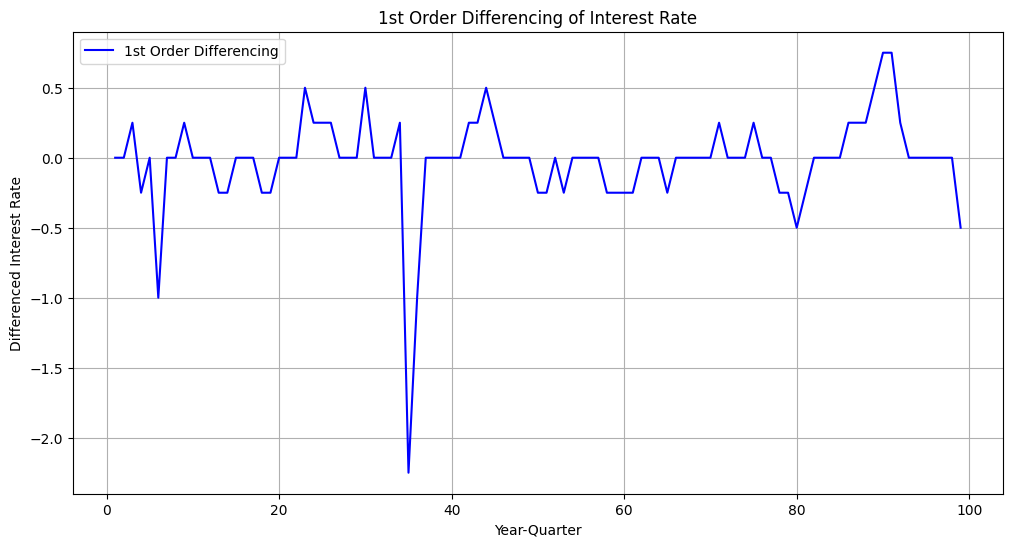

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(df['Interest Rate Diff'], label="1st Order Differencing", color="blue")
plt.xlabel("Year-Quarter")
plt.ylabel("Differenced Interest Rate")
plt.title("1st Order Differencing of Interest Rate")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
df['Interest Rate Diff2'] = df['Interest Rate Diff'].diff().dropna()

# 2차 차분 후 ADF 테스트 수행
adf_test_diff2 = adfuller(df['Interest Rate Diff2'].dropna())

print("ADF Statistic (After 2nd Differencing):", adf_test_diff2[0])
print("p-value (After 2nd Differencing):", adf_test_diff2[1])

if adf_test_diff2[1] < 0.05:
    print("✅ 2차 차분 후 데이터가 정상성을 가집니다.")
else:
    print("❌ 2차 차분 후에도 정상성이 확보되지 않았습니다. 추가적인 변환이 필요할 수 있습니다.")


ADF Statistic (After 2nd Differencing): -8.600781152856012
p-value (After 2nd Differencing): 6.87846716658236e-14
✅ 2차 차분 후 데이터가 정상성을 가집니다.


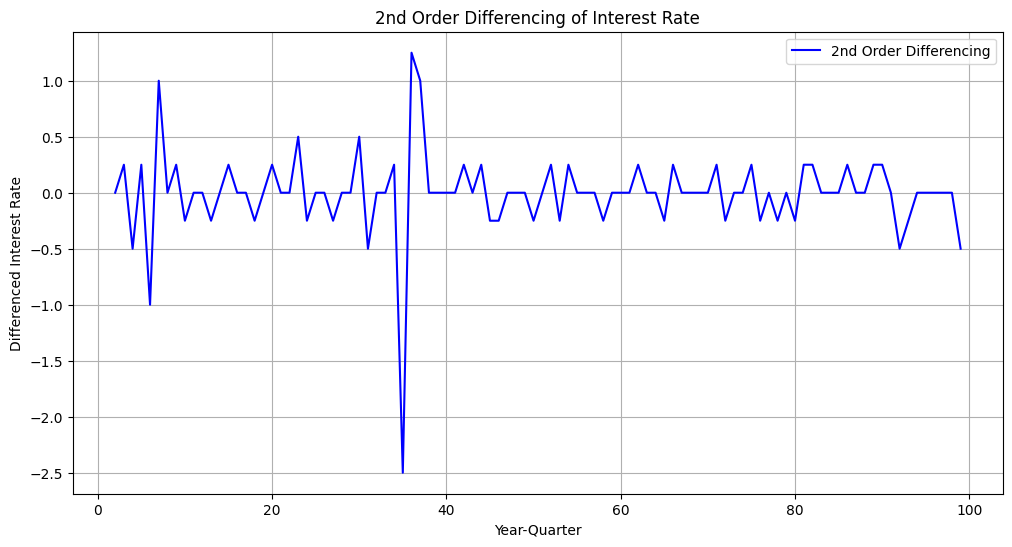

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(df['Interest Rate Diff2'], label="2nd Order Differencing", color="blue")
plt.xlabel("Year-Quarter")
plt.ylabel("Differenced Interest Rate")
plt.title("2nd Order Differencing of Interest Rate")
plt.legend()
plt.grid(True)
plt.show()

4. ARIMA 모델 적용

(1) Auto-ARIMA로 최적 p(AR), d(차분 횟수), q(MA) 값 찾기

In [ ]:
!pip install pmdarima  # Colab 환경에서 실행 시 필요

from pmdarima import auto_arima

# 📌 Auto-ARIMA로 최적의 p, d, q 찾기
stepwise_model = auto_arima(df['Interest Rate Diff'].dropna(),
                            seasonal=False,  # 계절성 반영 안 함 (필요 시 True로 변경 가능)
                            trace=True,  # 진행 과정 출력
                            suppress_warnings=True)

# 최적의 p, d, q 출력
print("Auto-ARIMA Best Order (p, d, q):", stepwise_model.order)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=63.306, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=70.896, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=58.504, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=60.694, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=60.494, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=60.495, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=61.805, Time=0.12 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=60.298, Time=0.06 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0]          
Total fit time: 0.470 seconds
Auto-ARIMA Best Order (p, d, q): (1, 0, 0)


(2) ARIMA 모델 학습 및 예측

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

# Auto-ARIMA에서 찾은 최적의 (p, d, q) 값 입력
p, d, q = stepwise_model.order  # Auto-ARIMA에서 찾은 값 적용

# 📌 ARIMA 모델 학습
arima_model = ARIMA(df['Interest Rate Diff'].dropna(), order=(p, d, q))
arima_result = arima_model.fit()

# 📌 모델 요약 출력
print(arima_result.summary())

# 📌 향후 8분기(2년) 예측
forecast_steps = 8
forecast = arima_result.forecast(steps=forecast_steps)

# 📌 예측 결과 출력
print("📌 향후 8분기 예측 (차분값):")
print(forecast)


                               SARIMAX Results                                
Dep. Variable:     Interest Rate Diff   No. Observations:                   99
Model:                 ARIMA(1, 0, 0)   Log Likelihood                 -27.149
Date:                Sun, 16 Mar 2025   AIC                             60.298
Time:                        14:04:57   BIC                             68.083
Sample:                             0   HQIC                            63.448
                                 - 99                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0229      0.076     -0.299      0.765      -0.173       0.127
ar.L1          0.3679      0.117      3.137      0.002       0.138       0.598
sigma2         0.1012      0.006     16.870      0.0

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be give

(3) 예측된 차분 값을 원래 금리값으로 변환(Inverse Differencing)

In [ ]:
# 📌 예측된 차분값을 원래 금리 데이터로 복원
last_actual_value = df['Interest Rate'].iloc[-1]  # 마지막 실제 금리 값
forecast_cumsum = forecast.cumsum()  # 누적합 계산
forecast_original = last_actual_value + forecast_cumsum  # 마지막 실제 값에 누적합을 더함

# 📌 최종 예측 결과 출력
print("📌 향후 8분기 금리 예측 (실제값 변환 후):")
print(forecast_original)


📌 향후 8분기 금리 예측 (실제값 변환 후):
99     2.801591
100    2.714136
101    2.667499
102    2.635880
103    2.609785
104    2.585723
105    2.562408
106    2.539368
Name: predicted_mean, dtype: float64


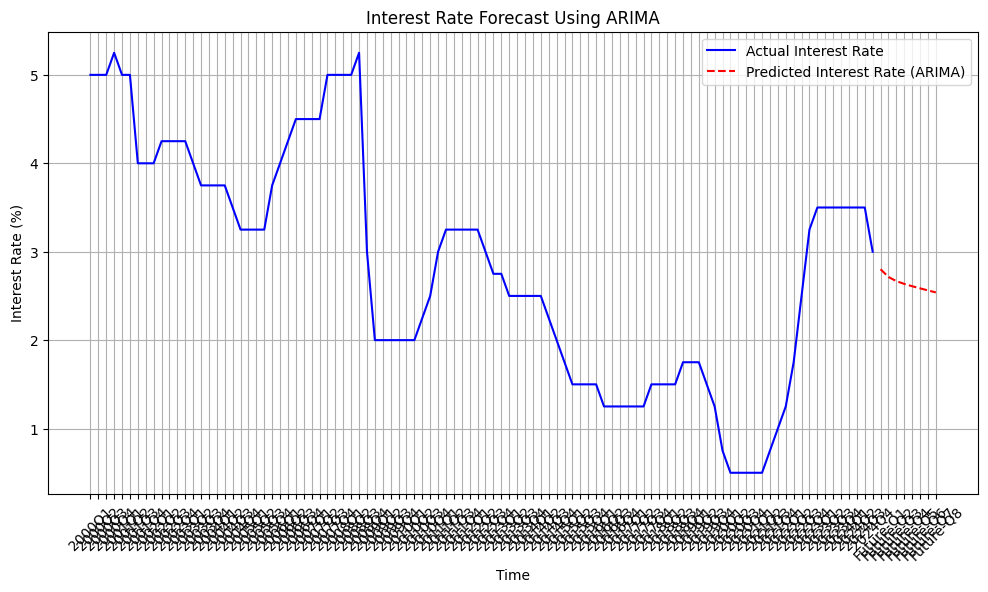

In [ ]:
import matplotlib.pyplot as plt

# 📌 기존 금리 데이터 시각화
plt.figure(figsize=(12, 6))
plt.plot(df['Quarter'], df['Interest Rate'], label="Actual Interest Rate", color="blue")

# 📌 예측 결과 추가
future_quarters = [f"Future-Q{i+1}" for i in range(len(forecast_original))]
plt.plot(future_quarters, forecast_original, label="Predicted Interest Rate (ARIMA)", color="red", linestyle="dashed")

# 📌 그래프 설정
plt.xlabel("Time")
plt.ylabel("Interest Rate (%)")
plt.title("Interest Rate Forecast Using ARIMA")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)

# 📌 그래프 출력
plt.show()
